# Implementing simplest NN with PyTorch
 

In [2]:
#Some necessory imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat

--2020-09-10 19:22:46--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  13.6MB/s    in 18s     

2020-09-10 19:23:04 (9.88 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]



In [5]:
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-09-10 19:23:29--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  15.3MB/s    in 9.4s    

2020-09-10 19:23:39 (6.50 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]



In [7]:
# First, lets load the dataset
data_train = dset.SVHN('.', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('.', split='test',
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

#Splitting the dataset via `SubsetRandomSampler` and `DataLoader`.

In [8]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [10]:
#Preparing for some visualizing
import scipy.io as io
X = io.loadmat('train_32x32.mat')
x = np.moveaxis(X['X'], 3, 0)

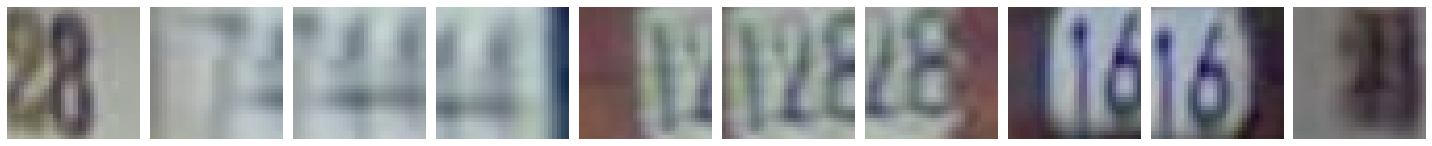

In [12]:
#Let's visualize some digits
plt.figure(figsize=(20, 25))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(x[i+12])
    plt.axis('off')
plt.tight_layout()

In [15]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)

class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


## Time to train!

In [21]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, sheduler):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() #Train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        sheduler.step()
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    model.eval()
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    val_accuracy = float(correct_samples) / total_samples
    return val_accuracy

In [22]:
#Creating an pretty simple model
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 1000),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.BatchNorm1d(1000),
    nn.Linear(1000, 100),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-3, momentum=0.5)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
sheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.5)
loss_history, train_history, val_history = train_model(nn_model,
    train_loader, val_loader,
        loss, optimizer, 6, sheduler)

Average loss: 1.244169, Train accuracy: 0.607054, Val accuracy: 0.695038
Average loss: 0.802155, Train accuracy: 0.753967, Val accuracy: 0.762064
Average loss: 0.655354, Train accuracy: 0.801641, Val accuracy: 0.788888
Average loss: 0.571863, Train accuracy: 0.828260, Val accuracy: 0.814893
Average loss: 0.519741, Train accuracy: 0.845750, Val accuracy: 0.827179
Average loss: 0.492973, Train accuracy: 0.852916, Val accuracy: 0.835301


In [29]:
#Check the test accuracy
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8092


Accuracy is more than 80% - not bad

# Visualize a mistakes

In [24]:
class SubsetSampler(Sampler):
    """Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    

def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    predictions = []
    ground_truth = []
    for x in SubsetSampler(indices).__iter__():
        pred = model(data_train[x][0].resize(1, 3, 32, 32))
        _, correct_index = torch.max(pred, 1)
        predictions.append(int(correct_index[0]))
        ground_truth.append(dataset[x][1])
    return predictions, ground_truth

predictions, gt = evaluate_model(nn_model, data_train, val_indices)

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


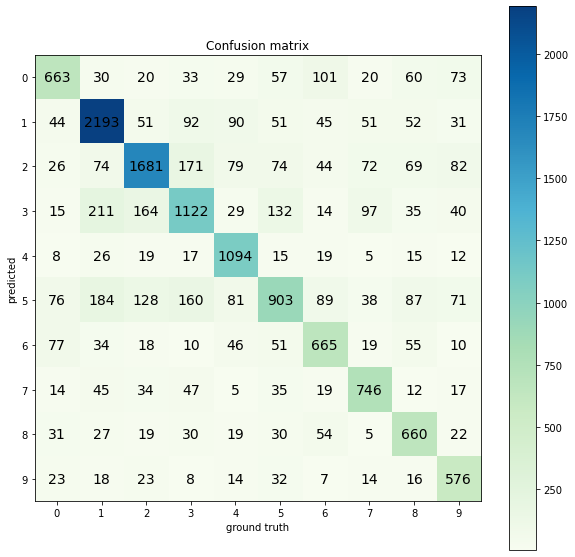

In [ ]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    for i in range(0, 10):
        for j in range (0, 10):
            model_true = [k for k,x in enumerate(predictions) if x==i]
            actual_true = [k for k,x in enumerate(gt) if x==j]
            confusion_matrix[i][j] = len(set(model_true) & set(actual_true))
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

#Let's Visualize the most frequent mistakes based on the confusion matrix
For example 3 and 5 digits recall

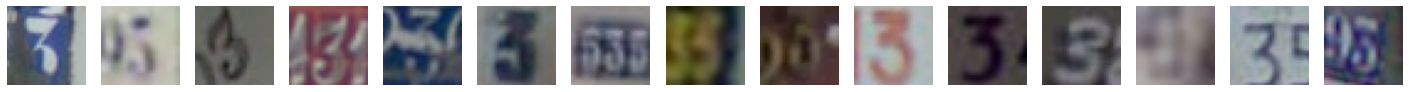

In [27]:
data_train_images = dset.SVHN('.', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(25,10))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index].copy()
        sample = np.moveaxis(sample, 0, 2)
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 

    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    confusion_matrix = np.zeros((10, 10), dtype=np.ndarray)
    for i in range(0, 10):
        for j in range (0, 10):
            model_true = [k for k,x in enumerate(predictions) if x==i]
            actual_true = [k for k,x in enumerate(gt) if x==j]
            confusion_matrix[i][j] = np.array(list(set(model_true) & set(actual_true)))
    visualize_images(confusion_matrix[predicted_class][gt_class], data.data[val_indices], max_num=15)

visualize_predicted_actual(5, 3, predictions, gt, np.array(val_indices), data_train_images)